<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# _Inteligencia Artificial vs Humanos en la Generación de Textos_<a id="top"></a>

<i>Raúl Andrino Gómez<br></i></div>
                                                  

---

### Introducción

Este trabajo explora las diferencias y similitudes entre textos generados por inteligencia artificial y aquellos creados por humanos. Utilizando técnicas de procesamiento del lenguaje natural (NLP), se examinan distintas características de los datos para identificar características que puedan mostrar la autoría de un texto. El objetivo es desarrollar un enfoque analítico que permita diferenciar eficazmente entre contenido humano y artificial, evaluando también la precisión y las limitaciones de los métodos de detección actuales.

### Importación las librerías necesarias

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
import pickle

### Carga de los datos

Se carga el CSV y se imprime una primera vista del mismo

In [ ]:
df = pd.read_csv("data/AI_Human.csv")

df

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


### Exploración de los datos

Obtención de características generales del DataFrame.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [4]:
df.duplicated().sum()

0

Se observa que los datos se encuentran en el formato correcto. Además, no se encuentran valores nulos ni duplicados

#### Número de textos por fuente de generación

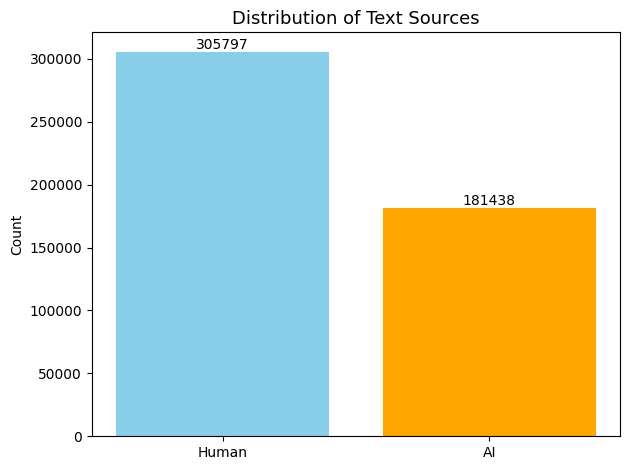

In [5]:
count_data = df['generated'].value_counts()

plt.bar([0, 1], count_data, color=['skyblue', 'orange'])
plt.xticks([0,1], ["Human", "AI"])
plt.xlabel('')
plt.ylabel('Count')
for index, value in count_data.items():
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Distribution of Text Sources', fontsize=13)
plt.tight_layout()
plt.show()

En la gráfica se observa que existe un número mayor de textos que han sido generados por humanos de los que han sido generados por IA

#### Balanceo de datos

Para solucionar este problema que puede generar sesgos en los modelos, se va a realizar un balanceo de datos, eligiendo al azar 100.000 muestras de cada tipo 

In [6]:
df_human = df[df['generated'] == 0].copy()
df_ia = df[df['generated'] == 1].copy()

df_human_balanced = df_human.sample(n=100000, random_state=42)
df_ia_balanced = df_ia.sample(n=100000, random_state=42)

df_balanced = pd.concat([df_human_balanced, df_ia_balanced], axis=0)

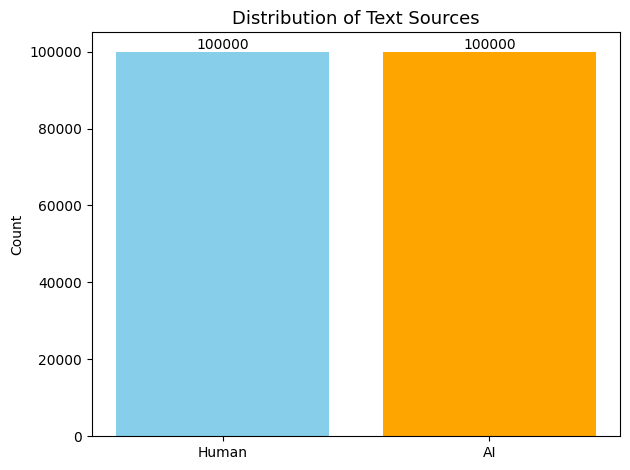

In [7]:
count_data = df_balanced['generated'].value_counts()

plt.bar([0, 1], count_data, color=['skyblue', 'orange'])
plt.xticks([0,1], ["Human", "AI"])
plt.xlabel('')
plt.ylabel('Count')
for index, value in count_data.items():
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Distribution of Text Sources', fontsize=13)
plt.tight_layout()
plt.show()

Como se puede observar en el gráfico, ahora los datos ya se encuentran balanceados, habiendo la misma proporción de ambos tipos

#### Correlación de cada tipo de texto por número de palabras

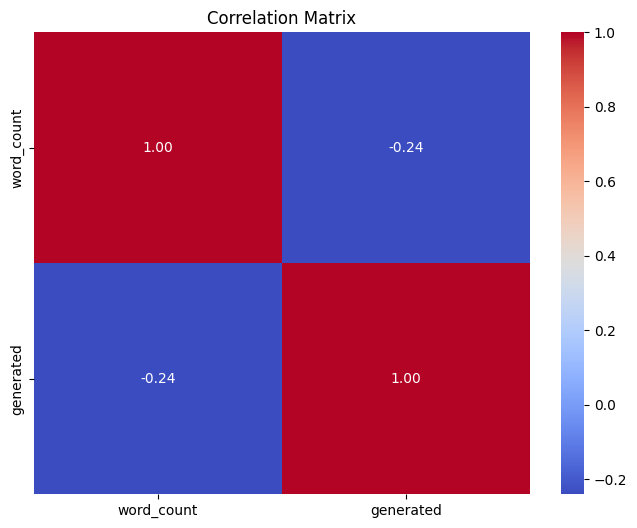

In [8]:
df_balanced['word_count'] = df_balanced['text'].apply(lambda x: len(str(x).split()))

correlation = df_balanced[['word_count', 'generated']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

La correlación obtenida es de -0.24, lo cual indica una correlación negativa débil. Esto sugiere que los textos generados por IA tienden a tener un número de palabras menor que los textos generados por humanos, aunque la relación no es muy fuerte.

#### Frecuencia de las palabras más comunes

Se crean dos funciones auxiliares para calcular la frecuencia de las 50 palabras más comunes, diferenciando por tipo de texto

In [9]:
def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

def plot_words(column, words):

    word_counter_human = counter_word(df_balanced[df_balanced["generated"] == 0][column])
    word_counter_ia = counter_word(df_balanced[df_balanced["generated"] == 1][column])

    n_words = words*2
    most_occur_words_human = word_counter_human.most_common(n_words)
    most_occur_words_ia = word_counter_ia.most_common(n_words)

    most_occur_words_human = pd.DataFrame(most_occur_words_human, columns=['word', 'count'])
    most_occur_words_ia = pd.DataFrame(most_occur_words_ia, columns=['word', 'count'])

    merged_df = pd.merge(most_occur_words_human, most_occur_words_ia, on='word', suffixes=('_human', '_ia'))

    # Mantener solo las 50 palabras más comunes
    merged_df = merged_df.head(words)
    
    bar_width = 0.35
    index = np.arange(len(merged_df))

    plt.figure(figsize=(12, 6))

    plt.bar(index, merged_df['count_human'], bar_width, label='Human', color="skyblue")

    plt.bar(index + bar_width, merged_df['count_ia'], bar_width, label='IA', color='orange')

    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title('Top 50 Most Common Words')

    plt.xticks(index + bar_width / 2, merged_df['word'], rotation=90)

    plt.legend()
    plt.tight_layout()
    plt.show()

Se imprime el gráfico

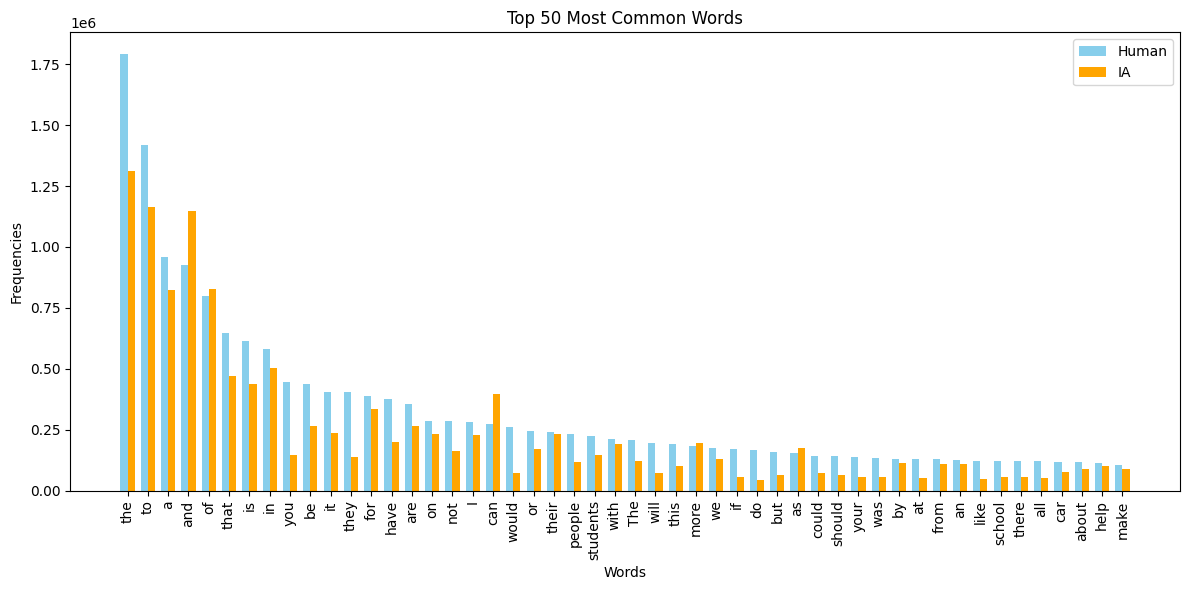

In [10]:
plot_words('text', 50)

Las palabras más comunes son similares entre ambos gráficos, lo cual es esperable, ya que estas palabras son tipicamante palabras funcionales (_stopwords_) que aparecen en casi cualquier tipo de texto en inglés.

Estas palabras no aportan un significado en sí mismo, pero son esenciales para la estructura gramatical de las oraciones. Aun así, se van a eliminar de los textos para reducir el tamaño del vocabulario y conseguir que los modelos sean más eficientes y fáciles de entrenar

Así, se procede a eliminar las mencionadas palabras de los textos, almacenando los nuevos textos en una nueva columna del DataFrame llamada _text_cleaned_

In [11]:
# Descargar las stopwords en inglés
nltk.download('stopwords')

# Obtener las stopwords del idioma inglés de nltk
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = re.sub(r'[^\w\s]', '', text.lower()).split()
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

df_balanced['text_cleaned'] = df_balanced['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se realiza el mismo gráfico de frecuencia de palabras, pero habiendo eliminado las stopwords previamente.

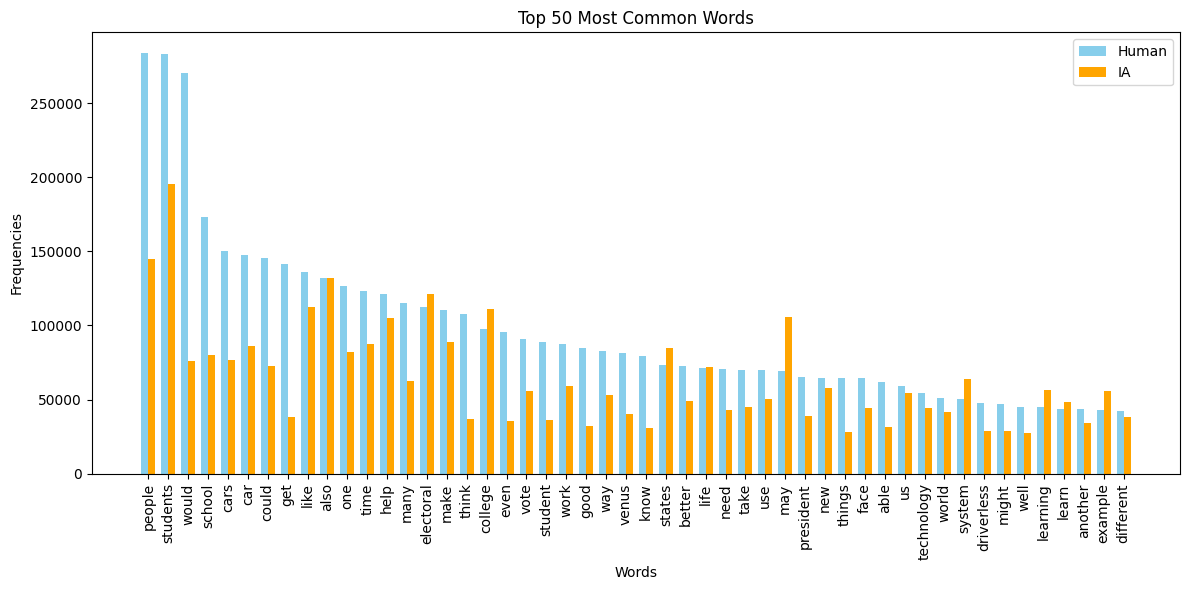

In [12]:
plot_words('text_cleaned', 50)

A diferencia de la gráfica anterior, aquí se observan palabras más representativas del contenido específico de los textos, en lugar de palabras funcionales como "the", "to", "and", etc.

La eliminación de las stopwords permite que las palabras más relevantes se destaquen, facilitando el análisis comparativo de los patrones de lenguaje entre humanos y sistemas de IA.

Sin embargo, se puede notar que los textos humanos tienden a enfatizar términos como "people", "students" y "school", mientras que en los textos generados por IA, algunos términos como "may" muestran una frecuencia relativamente alta. Esto puede provocar que el modelo distinga la fuente de generación del texto en función del tema del que habla el texto, provocando que el modelo prediga peor.

#### Correlación de cada tipo de texto por número de palabras 2

Se vuelve a realizar la misma matriz de correlación para ver el cambio que ha habido después de eliminar las stopwords.

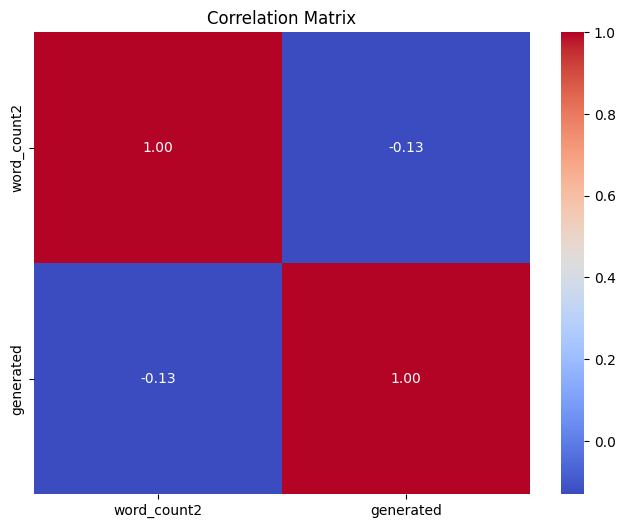

In [13]:
df_balanced['word_count2'] = df_balanced['text_cleaned'].apply(lambda x: len(str(x).split()))
correlation = df_balanced[['word_count2', 'generated']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Se observa una mejora en la correlación, es decir, esta es todavía más débil que en el caso anterior. De esta manera, el modelo no se puede basar en la cantidad de palabras para discesnir la fuente de generación del texto, mejorando el rendimiento del mismo.

#### Distribución de los textos por número de palabras

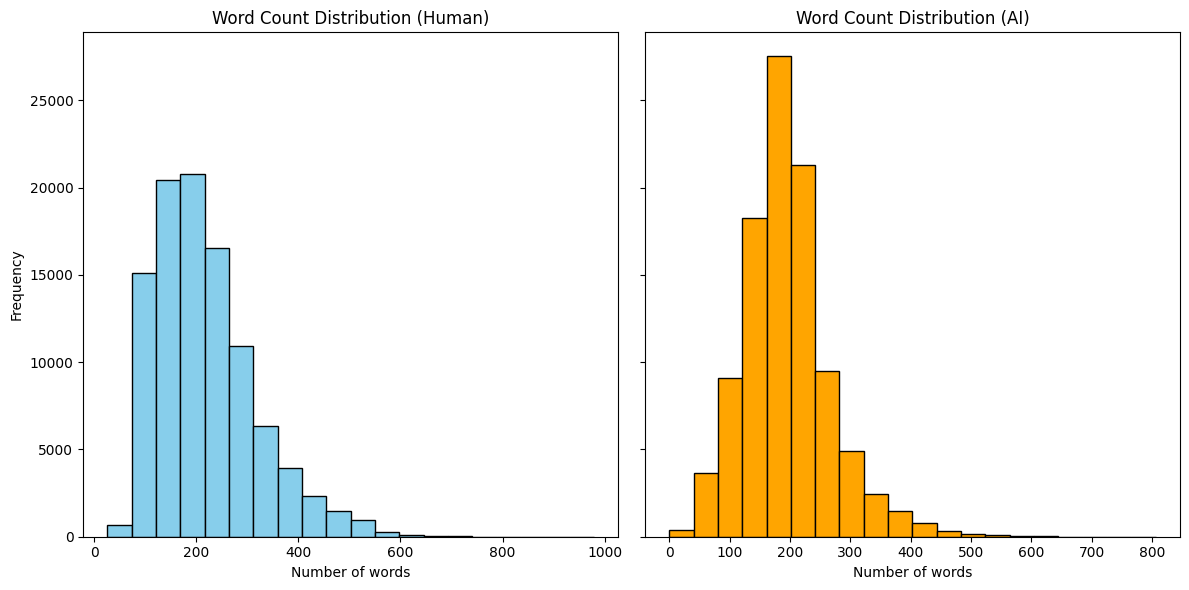

In [14]:
text_length_human = df_balanced[df_balanced['generated'] == 0]['word_count2']
text_length_ia = df_balanced[df_balanced['generated'] == 1]['word_count2']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hist(text_length_human, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Word Count Distribution (Human)')
axes[0].set_xlabel('Number of words')
axes[0].set_ylabel('Frequency')

axes[1].hist(text_length_ia, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Word Count Distribution (AI)')
axes[1].set_xlabel('Number of words')

plt.tight_layout()

plt.show()

En el caso de los textos humanos, la distribución está ligeramente desplazada hacia textos más largos, alcanzando su pico alrededor de 200-250 palabras y extendiéndose hasta 600 palabras o más en algunos casos. Esto sugiere que los textos generados por humanos tienden a ser un poco más variados en longitud y, en algunos casos, más extensos que los textos generados por IA.

Por otro lado, la distribución de los textos generados por IA muestra un pico más definido alrededor de las 150-200 palabras, y luego decae rápidamente. Esto sugiere que los textos de IA tienden a tener una longitud más estandarizada, con menor variabilidad en comparación con los textos humanos.

Estas diferencias en la longitud de los textos pueden ser útiles para la clasificación, ya que la longitud del texto es un indicio de estilo de escritura. Sin embargo, también puede ser perjudicial, pues el modelo puede predecir basándose únicamente en la longitud de los textos.

Teniendo en cuenta el gráfico, para los modelos posteriores, se va a elegir como máxima longitud de las secuencias 500 tokens

### Preprocesado de los textos

División de los textos en train (70%), validation (15%) y test (15%)

In [15]:
df_final = df_balanced[['text_cleaned', 'generated']]

# Dividir los datos en train (70%) y test/validation (30%)
train_df, test_val_df = train_test_split(df_final, test_size=0.3, random_state=42, stratify=df_final['generated'])

# Dividir test_val_df en test (50%) y validation (50%) de los datos restantes (15% cada uno)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['generated'])

Creación de una función customizada de estandarización para los textos. Además, se crea una función auxiliar para poner los textos en el formato adecuado para posteriormente introducirlos en los modelos.

In [16]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

def format(train_df, test_df, val_df, text_vectorizer):

    # Crear un Dataset de TensorFlow
    train = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_df['text_cleaned'].values, dtype=tf.string),
                                                tf.convert_to_tensor(train_df['generated'].values, dtype=tf.int32)))

    # Habilitar prefetching para mejorar el rendimiento
    train = train.shuffle(buffer_size=len(train)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    test = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_df['text_cleaned'].values, dtype=tf.string),
                                                tf.convert_to_tensor(test_df['generated'].values, dtype=tf.int32)))

    test = test.shuffle(buffer_size=len(df)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    val = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_df['text_cleaned'].values, dtype=tf.string),
                                                tf.convert_to_tensor(val_df['generated'].values, dtype=tf.int32)))

    val = val.shuffle(buffer_size=len(df)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    # Almacenar pares <texto vectorizado, etiqueta> para entrenar el modelo
    train_ds = train.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=4)
    val_ds = val.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=4)
    test_ds = test.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=4)

    return train_ds, val_ds, test_ds

### Modelos

Creación de dos funciones auxiliares

_plot_: Crea un gráfico del historial del entrenamiento del modelo

_predict_: Preprocesa un texto introducido como argumento para, posteriormente, obtener la predicción del modelo.

In [25]:
def plot(h, epochs, metric):
  LOSS= 0;ACCURACY= 1
  training = np.zeros((2,epochs)); testing = np.zeros((2,epochs)) 
  training[LOSS] = h['loss']
  testing[LOSS] = h['val_loss'] # validation loss 
  training[ACCURACY] = h[metric]
  testing[ACCURACY] = h['val_'+ metric]
  epochs = range(1,epochs+1)
  fig,axs = plt.subplots(1,2, figsize=(17,5)) 
  for i , label in zip((LOSS, ACCURACY),('loss',metric)):
    axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
    axs[i].plot(epochs, testing[i], 'y-', label='Val ' + label)
    axs[i].set_title('Training and validation ' + label)
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(label)
    axs[i].legend()
    axs[i].grid(True)
  plt.show()

def predict(raw_text):
  raw_text = tf.convert_to_tensor([[raw_text]])
  predicitons = inference_model(raw_text)
  print(f"{float(predicitons[0] * 100):.2f} % AI generated")

#### Codificación bag of words + red neuronal simple

Preprocesado de los textos con codificación bag of words y 30000 tokens de vocabulario 

In [18]:
max_length = None
max_tokens = 30000
out = "multi_hot"

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                    output_mode=out,
                                    standardize=custom_standardization,
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_df['text_cleaned'].values)

print(text_vectorizer.get_vocabulary()[:10])

train_ds, val_ds, test_ds = format(train_df, test_df, val_df, text_vectorizer)

['[UNK]', 'students', 'people', 'would', 'also', 'school', 'like', 'electoral', 'car', 'help']


Diseño del modelo

In [19]:
EPOCHS = 10

inputs = keras.Input(shape=(30000,), dtype="int64")
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       960,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,065 (3.66 MB)

 Trainable params: 960,065 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo, guardando tanto el propio modelo como el historial

In [ ]:
history = model.fit(train_ds.cache(),
           validation_data=val_ds.cache(),
           epochs=EPOCHS)

model.save("models/model_1.keras")

with open('models/model_1_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 68s 15ms/step - accuracy: 0.9771 - loss: 0.0734 - val_accuracy: 0.9932 - val_loss: 0.0253
Epoch 2/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 73s 17ms/step - accuracy: 0.9934 - loss: 0.0257 - val_accuracy: 0.9944 - val_loss: 0.0221
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/step - accuracy: 0.9953 - loss: 0.0189 - val_accuracy: 0.9951 - val_loss: 0.0200
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 69s 16ms/step - accuracy: 0.9961 - loss: 0.0157 - val_accuracy: 0.9955 - val_loss: 0.0204
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accuracy: 0.9968 - loss: 0.0130 - val_accuracy: 0.9961 - val_loss: 0.0182
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - accuracy: 0.9976 - loss: 0.0105 - val_accuracy: 0.9962 - val_loss: 0.0180
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accuracy: 0.9979 - loss: 0.0090 - val_accuracy: 0.9965 - val_loss: 0.0167
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - accuracy: 0.9982 -

Carga del modelo y del historial

In [ ]:
model = keras.models.load_model("models/model_1.keras")

with open('models/model_1_history.pkl', 'rb') as f:
    history = pickle.load(f)

Gráfico del historial del entrenamiento

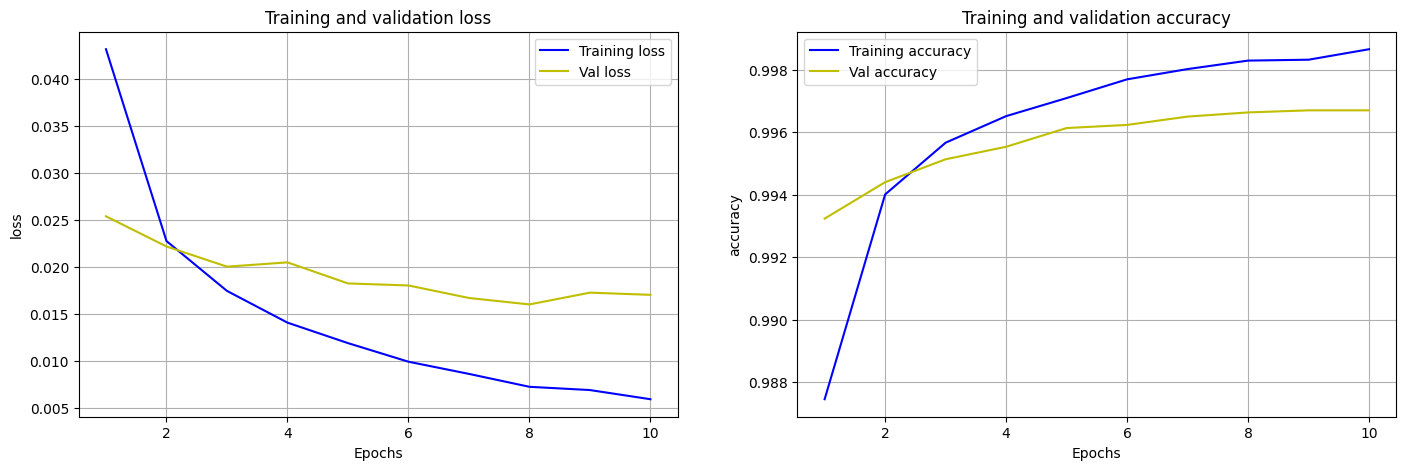

In [21]:
plot(history, EPOCHS, 'accuracy')

Testeo del modelo

In [22]:
print(f"Test accuracy: {model.evaluate(test_ds)[1]*100:.2f} %")

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9970 - loss: 0.0118
Test accuracy: 99.75 %


##### Pruebas del modelo con textos

Se prueba el modelo con distintos textos y su correspondiente versión escrita por una IA

Creación de un modelo que admite un texto como entrada, lo normaliza, tokeniza y vectoriza y, finalmente, procesa.

In [23]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorizer(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

Texto escrito a mano

In [26]:
# Human version
print("Human version:")

raw_text = """I am the manager of ALTAIR's sales department and I am very upset to hear that you are disappointed with the quality of our software. I would like to apologize to you and ask for more information about your problems with the software.
On the other hand, I inform you that the refund of the money is impossible as stated in the sales contract. However, in some cases we have a customer support policy. A person from our technical department is going to visit your company and check the software running in your computers. Afterwards, a detailed report will be prepared.
Finally, on behalf of the company I must apologize for any inconvenience caused and I would like to offer you the possibility to arrange a meeting to discuss the solutions based on the report. You are one of the most important customer of our company and it would not be pleasant lose our business relationship.
If you have any questions please do not hesitate to contact me and I look forward to hearing from you."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """As the manager of ALTAIR's sales department, I am very sorry to hear about your dissatisfaction with our software. I want to personally apologize and kindly request more details regarding the specific issues you've encountered.
That said, I must inform you that, as outlined in the sales contract, a refund is not possible. However, we do have a customer support policy that may assist in resolving your concerns. A member of our technical team will visit your company to review the software's performance on your systems and prepare a detailed report.
On behalf of ALTAIR, I sincerely apologize for any inconvenience this has caused. I would also like to offer a meeting to discuss potential solutions based on the findings of the report. Your company is a valued client, and we are committed to maintaining our business relationship.
If you have any questions, please don't hesitate to reach out. I look forward to hearing from you."""

predict(raw_text)

Human version:
17.03 % AI generated

AI version:
100.00 % AI generated


The Lord of the Rings, Book 5 Chapter 3, primeros 3 párrafos

In [27]:
# Human version
print("Human version:")

raw_text = """Now all roads were running together to the East to meet the coming of war and the onset of the Shadow. And even as Pippin stood at the Great Gate of the City and saw the Prince of Dol Amroth ride in with his banners, the King of Rohan came down out of the hills. Day was waning. In the last rays of the sun the Riders cast long pointed shadows that went on before them. Darkness had already crept beneath the murmuring fir-woods that clothed the steep mountain-sides.
The king rode now slowly at the end of the day. Presently the path turned round a huge bare shoulder of rock and plunged into the gloom of soft-sighing trees. Down, down they went in a long winding file. When at last they came to the bottom of the gorge they found that evening had fallen in the deep places. The sun was gone. Twilight lay upon the waterfalls.
All day far below them a leaping stream had run down from the high pass behind, cleaving its narrow way between pine-clad walls; and now through a stony gate it flowed out and passed into a wider vale. The Riders followed it, and suddenly Harrowdale lay before them, loud with the noise of waters in the evening. There the white Snowbourn, joined by the lesser stream, went rushing, fuming on the stones, down to Edoras and the green hills and the plains. Away to the right at the head of the great dale the mighty Starkhorn loomed up above its vast buttresses swathed in cloud; but its jagged peak, clothed in everlasting snow, gleamed far above the world, blue-shadowed upon the East, red-stained by the sunset in the West."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Now all the roads converged to the East, drawn to meet the approaching war and the gathering Shadow. As Pippin stood at the City’s Great Gate, watching the Prince of Dol Amroth arrive with his banners, the King of Rohan descended from the hills. The day was fading. In the last sunlight, the Riders cast long, pointed shadows stretching out before them, while darkness had already seeped into the murmuring fir trees that cloaked the steep mountainsides.
The king now rode slowly, the day drawing to a close. The path soon curved around a massive, bare shoulder of rock and plunged into the dimness of softly sighing trees. Down and down they traveled in a long, winding line. When they finally reached the bottom of the gorge, evening had settled thick in the deep places. The sun had disappeared, and twilight lay over the waterfalls.
All day, far below them, a tumbling stream had coursed down from the high pass behind, carving its narrow path between pine-lined walls. Now it flowed through a rocky gate and spread into a broader valley. The Riders followed it until Harrowdale appeared before them, echoing with the roar of evening waters. There, the Snowbourn River, joined by the smaller stream, rushed and fumed over stones, flowing down toward Edoras and the green hills and plains. To the right, at the head of the great valley, the mighty Starkhorn towered above, its vast buttresses draped in clouds. Its jagged peak, clothed in eternal snow, shone far above the world, blue-shadowed in the East, stained red by the sunset in the West."""

predict(raw_text)

Human version:
7.04 % AI generated

AI version:
100.00 % AI generated


Fragmento de la Wikipedia de [Albert Einstein](https://en.wikipedia.org/wiki/Albert_Einstein)

In [28]:
# Human version
print("Human version:")

raw_text = """Correspondence between Einstein and Marić, discovered and published in 1987, revealed that in early 1902, while Marić was visiting her parents in Novi Sad, she gave birth to a daughter, Lieserl. When Marić returned to Switzerland it was without the child, whose fate is uncertain. A letter of Einstein's that he wrote in September 1903 suggests that the girl was either given up for adoption or died of scarlet fever in infancy.
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wrote to Marie Winteler in the months before Eduard's arrival, he described his love for his wife as "misguided" and mourned the "missed life" that he imagined he would have enjoyed if he had married Winteler instead: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein entered into a relationship with Elsa Löwenthal, who was both his first cousin on his mother's side and his second cousin on his father's. When Marić learned of his infidelity soon after moving to Berlin with him in April 1914, she returned to Zürich, taking Hans Albert and Eduard with her. Einstein and Marić were granted a divorce on 14 February 1919 on the grounds of having lived apart for five years. As part of the divorce settlement, Einstein agreed that if he were to win a Nobel Prize, he would give the money that he received to Marić; he won the prize two years later.
Einstein married Löwenthal in 1919. In 1923, he began a relationship with a secretary named Betty Neumann, the niece of his close friend Hans Mühsam. Löwenthal nevertheless remained loyal to him, accompanying him when he emigrated to the United States in 1933. In 1935, she was diagnosed with heart and kidney problems. She died in December 1936."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """In 1987, previously unknown correspondence between Einstein and Marić surfaced, revealing that Marić had given birth to a daughter named Lieserl in early 1902 while visiting her parents in Novi Sad. When Marić returned to Switzerland, the child was not with her, and her fate remains unclear. In a letter Einstein wrote in September 1903, he implied that Lieserl might have been put up for adoption or succumbed to scarlet fever while still an infant.
Einstein and Marić married in January 1903, and the following year, in May 1904, their first son, Hans Albert, was born in Bern, Switzerland. Their second son, Eduard, arrived in Zürich in July 1910. Leading up to Eduard’s birth, Einstein wrote to Marie Winteler, expressing regret over not marrying her instead, referring to his love for Marić as "misguided" and lamenting the "missed life" he believed he would have had with Winteler: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein began an affair with Elsa Löwenthal, his first cousin on his mother's side and his second cousin on his father's. After relocating with Einstein to Berlin in April 1914, Marić discovered his infidelity and soon returned to Zürich with their sons, Hans Albert and Eduard. Their marriage ended in divorce on February 14, 1919, following a five-year separation. As part of the settlement, Einstein promised to give Marić any future Nobel Prize winnings, which he did two years later when he won the award.
Einstein married Löwenthal in 1919, yet by 1923, he was involved with Betty Neumann, the niece of his friend Hans Mühsam. Despite this, Löwenthal stayed by his side, even accompanying him to the United States in 1933. She developed heart and kidney issues in 1935 and passed away in December 1936."""

predict(raw_text)

Human version:
92.68 % AI generated

AI version:
100.00 % AI generated


#### Codificación tf-idf con bigramas + red neuronal simple

Preprocesado de los textos con codificación tf-idf con bigramas y 30000 tokens de vocabulario

In [29]:
max_length = None
max_tokens = 30000
out = "tf-idf"

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                    output_mode=out,
                                    standardize=custom_standardization,
                                    output_sequence_length=max_length,
                                    ngrams=2)

text_vectorizer.adapt(train_df['text_cleaned'].values)

train_ds, val_ds, test_ds = format(train_df, test_df, val_df, text_vectorizer)

Diseño del modelo

In [30]:
EPOCHS = 10

inputs = keras.Input(shape=(30000,), dtype="int64")
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       960,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,065 (3.66 MB)

 Trainable params: 960,065 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo, guardando tanto el propio modelo como el historial

In [ ]:
history = model.fit(train_ds.cache(),
          validation_data=val_ds.cache(),
          epochs=EPOCHS)

model.save("models/model_2.keras")

with open('models/model_2_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - accuracy: 0.9636 - loss: 0.1159 - val_accuracy: 0.9930 - val_loss: 0.0303
Epoch 2/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 90s 20ms/step - accuracy: 0.9916 - loss: 0.0384 - val_accuracy: 0.9941 - val_loss: 0.0257
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 94s 22ms/step - accuracy: 0.9941 - loss: 0.0279 - val_accuracy: 0.9957 - val_loss: 0.0212
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 97s 22ms/step - accuracy: 0.9953 - loss: 0.0228 - val_accuracy: 0.9964 - val_loss: 0.0216
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.9962 - loss: 0.0219 - val_accuracy: 0.9969 - val_loss: 0.0181
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.9967 - loss: 0.0197 - val_accuracy: 0.9965 - val_loss: 0.0211
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 90s 20ms/step - accuracy: 0.9969 - loss: 0.0178 - val_accuracy: 0.9971 - val_loss: 0.0191
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - accuracy: 0.9968

Carga del modelo y del historial

In [ ]:
model = keras.models.load_model("models/model_2.keras")

with open('models/model_2_history.pkl', 'rb') as f:
    history = pickle.load(f)

Gráfico del historial del entrenamiento

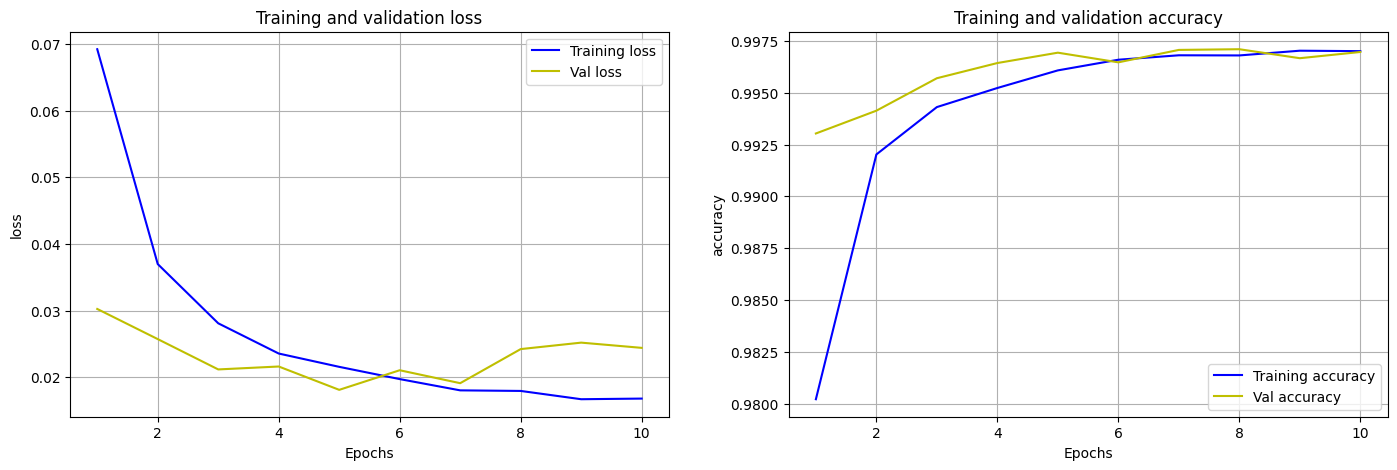

In [32]:
plot(history, EPOCHS, 'accuracy')

Testeo del modelo

In [33]:
print(f"Test accuracy: {model.evaluate(test_ds)[1]*100:.2f} %")

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9969 - loss: 0.0182
Test accuracy: 99.69 %


##### Pruebas del modelo con textos

Se prueba el modelo con distintos textos y su correspondiente versión escrita por una IA

Creación de un modelo que admite un texto como entrada, lo normaliza, tokeniza y vectoriza y, finalmente, procesa.

In [34]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorizer(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

Texto escrito a mano

In [35]:
# Human version
print("Human version:")

raw_text = """I am the manager of ALTAIR's sales department and I am very upset to hear that you are disappointed with the quality of our software. I would like to apologize to you and ask for more information about your problems with the software.
On the other hand, I inform you that the refund of the money is impossible as stated in the sales contract. However, in some cases we have a customer support policy. A person from our technical department is going to visit your company and check the software running in your computers. Afterwards, a detailed report will be prepared.
Finally, on behalf of the company I must apologize for any inconvenience caused and I would like to offer you the possibility to arrange a meeting to discuss the solutions based on the report. You are one of the most important customer of our company and it would not be pleasant lose our business relationship.
If you have any questions please do not hesitate to contact me and I look forward to hearing from you."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """As the manager of ALTAIR's sales department, I am very sorry to hear about your dissatisfaction with our software. I want to personally apologize and kindly request more details regarding the specific issues you've encountered.
That said, I must inform you that, as outlined in the sales contract, a refund is not possible. However, we do have a customer support policy that may assist in resolving your concerns. A member of our technical team will visit your company to review the software's performance on your systems and prepare a detailed report.
On behalf of ALTAIR, I sincerely apologize for any inconvenience this has caused. I would also like to offer a meeting to discuss potential solutions based on the findings of the report. Your company is a valued client, and we are committed to maintaining our business relationship.
If you have any questions, please don't hesitate to reach out. I look forward to hearing from you."""

predict(raw_text)

Human version:
100.00 % AI generated

AI version:
100.00 % AI generated


The Lord of the Rings, Book 5 Chapter 3, primeros 3 párrafos

In [36]:
# Human version
print("Human version:")

raw_text = """Now all roads were running together to the East to meet the coming of war and the onset of the Shadow. And even as Pippin stood at the Great Gate of the City and saw the Prince of Dol Amroth ride in with his banners, the King of Rohan came down out of the hills. Day was waning. In the last rays of the sun the Riders cast long pointed shadows that went on before them. Darkness had already crept beneath the murmuring fir-woods that clothed the steep mountain-sides.
The king rode now slowly at the end of the day. Presently the path turned round a huge bare shoulder of rock and plunged into the gloom of soft-sighing trees. Down, down they went in a long winding file. When at last they came to the bottom of the gorge they found that evening had fallen in the deep places. The sun was gone. Twilight lay upon the waterfalls.
All day far below them a leaping stream had run down from the high pass behind, cleaving its narrow way between pine-clad walls; and now through a stony gate it flowed out and passed into a wider vale. The Riders followed it, and suddenly Harrowdale lay before them, loud with the noise of waters in the evening. There the white Snowbourn, joined by the lesser stream, went rushing, fuming on the stones, down to Edoras and the green hills and the plains. Away to the right at the head of the great dale the mighty Starkhorn loomed up above its vast buttresses swathed in cloud; but its jagged peak, clothed in everlasting snow, gleamed far above the world, blue-shadowed upon the East, red-stained by the sunset in the West."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Now all the roads converged to the East, drawn to meet the approaching war and the gathering Shadow. As Pippin stood at the City’s Great Gate, watching the Prince of Dol Amroth arrive with his banners, the King of Rohan descended from the hills. The day was fading. In the last sunlight, the Riders cast long, pointed shadows stretching out before them, while darkness had already seeped into the murmuring fir trees that cloaked the steep mountainsides.
The king now rode slowly, the day drawing to a close. The path soon curved around a massive, bare shoulder of rock and plunged into the dimness of softly sighing trees. Down and down they traveled in a long, winding line. When they finally reached the bottom of the gorge, evening had settled thick in the deep places. The sun had disappeared, and twilight lay over the waterfalls.
All day, far below them, a tumbling stream had coursed down from the high pass behind, carving its narrow path between pine-lined walls. Now it flowed through a rocky gate and spread into a broader valley. The Riders followed it until Harrowdale appeared before them, echoing with the roar of evening waters. There, the Snowbourn River, joined by the smaller stream, rushed and fumed over stones, flowing down toward Edoras and the green hills and plains. To the right, at the head of the great valley, the mighty Starkhorn towered above, its vast buttresses draped in clouds. Its jagged peak, clothed in eternal snow, shone far above the world, blue-shadowed in the East, stained red by the sunset in the West."""

predict(raw_text)

Human version:
100.00 % AI generated

AI version:
100.00 % AI generated


Fragmento de la Wikipedia de [Albert Einstein](https://en.wikipedia.org/wiki/Albert_Einstein)

In [37]:
# Human version
print("Human version:")

raw_text = """Correspondence between Einstein and Marić, discovered and published in 1987, revealed that in early 1902, while Marić was visiting her parents in Novi Sad, she gave birth to a daughter, Lieserl. When Marić returned to Switzerland it was without the child, whose fate is uncertain. A letter of Einstein's that he wrote in September 1903 suggests that the girl was either given up for adoption or died of scarlet fever in infancy.
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wrote to Marie Winteler in the months before Eduard's arrival, he described his love for his wife as "misguided" and mourned the "missed life" that he imagined he would have enjoyed if he had married Winteler instead: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein entered into a relationship with Elsa Löwenthal, who was both his first cousin on his mother's side and his second cousin on his father's. When Marić learned of his infidelity soon after moving to Berlin with him in April 1914, she returned to Zürich, taking Hans Albert and Eduard with her. Einstein and Marić were granted a divorce on 14 February 1919 on the grounds of having lived apart for five years. As part of the divorce settlement, Einstein agreed that if he were to win a Nobel Prize, he would give the money that he received to Marić; he won the prize two years later.
Einstein married Löwenthal in 1919. In 1923, he began a relationship with a secretary named Betty Neumann, the niece of his close friend Hans Mühsam. Löwenthal nevertheless remained loyal to him, accompanying him when he emigrated to the United States in 1933. In 1935, she was diagnosed with heart and kidney problems. She died in December 1936."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """In 1987, previously unknown correspondence between Einstein and Marić surfaced, revealing that Marić had given birth to a daughter named Lieserl in early 1902 while visiting her parents in Novi Sad. When Marić returned to Switzerland, the child was not with her, and her fate remains unclear. In a letter Einstein wrote in September 1903, he implied that Lieserl might have been put up for adoption or succumbed to scarlet fever while still an infant.
Einstein and Marić married in January 1903, and the following year, in May 1904, their first son, Hans Albert, was born in Bern, Switzerland. Their second son, Eduard, arrived in Zürich in July 1910. Leading up to Eduard’s birth, Einstein wrote to Marie Winteler, expressing regret over not marrying her instead, referring to his love for Marić as "misguided" and lamenting the "missed life" he believed he would have had with Winteler: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein began an affair with Elsa Löwenthal, his first cousin on his mother's side and his second cousin on his father's. After relocating with Einstein to Berlin in April 1914, Marić discovered his infidelity and soon returned to Zürich with their sons, Hans Albert and Eduard. Their marriage ended in divorce on February 14, 1919, following a five-year separation. As part of the settlement, Einstein promised to give Marić any future Nobel Prize winnings, which he did two years later when he won the award.
Einstein married Löwenthal in 1919, yet by 1923, he was involved with Betty Neumann, the niece of his friend Hans Mühsam. Despite this, Löwenthal stayed by his side, even accompanying him to the United States in 1933. She developed heart and kidney issues in 1935 and passed away in December 1936."""

predict(raw_text)

Human version:
100.00 % AI generated

AI version:
100.00 % AI generated


#### Codificación "int" + Transformer encoder

Creación de la capa _TransformerEncoder_

In [38]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None): # Aquí se construye el Transformer
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Preprocesado de los textos con codificación int, 30000 tokens de vocabulario y 500 tokens de longitud máxima de secuencia

In [39]:
max_length = 500
max_tokens = 30000
out = "int"

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                    output_mode=out,
                                    standardize=custom_standardization,
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_df['text_cleaned'].values)

train_ds, val_ds, test_ds = format(train_df, test_df, val_df, text_vectorizer)

Diseño del modelo

In [40]:
embed_dim = 128
num_heads = 2
dense_dim = 32
EPOCHS = 10

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_tokens, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, None, 128)      │       140,832 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,980,961 (15.19 MB)

 Trainable params: 3,980,961 (15.19 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo, guardando tanto el propio modelo como el historial

In [ ]:
history = model.fit(train_ds.cache(),
          validation_data=val_ds.cache(),
          epochs=EPOCHS, batch_size=128)

model.save("models/model_3.keras")

with open('models/model_3_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1397s 319ms/step - accuracy: 0.9445 - loss: 0.1443 - val_accuracy: 0.9868 - val_loss: 0.0384
Epoch 2/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1361s 311ms/step - accuracy: 0.9856 - loss: 0.0434 - val_accuracy: 0.9905 - val_loss: 0.0294
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1305s 298ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.9930 - val_loss: 0.0236
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1305s 298ms/step - accuracy: 0.9918 - loss: 0.0265 - val_accuracy: 0.9947 - val_loss: 0.0217
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1305s 298ms/step - accuracy: 0.9932 - loss: 0.0220 - val_accuracy: 0.9945 - val_loss: 0.0206
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1307s 299ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9952 - val_loss: 0.0183
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1306s 299ms/step - accuracy: 0.9956 - loss: 0.0152 - val_accuracy: 0.9954 - val_loss: 0.0190
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1307s 299ms/step - accur

Carga del modelo y del historial

In [ ]:
model = keras.models.load_model("models/model_3.keras", custom_objects={'TransformerEncoder': TransformerEncoder})

with open('models/model_3_history.pkl', 'rb') as f:
    history = pickle.load(f)

c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Gráfico del historial del entrenamiento

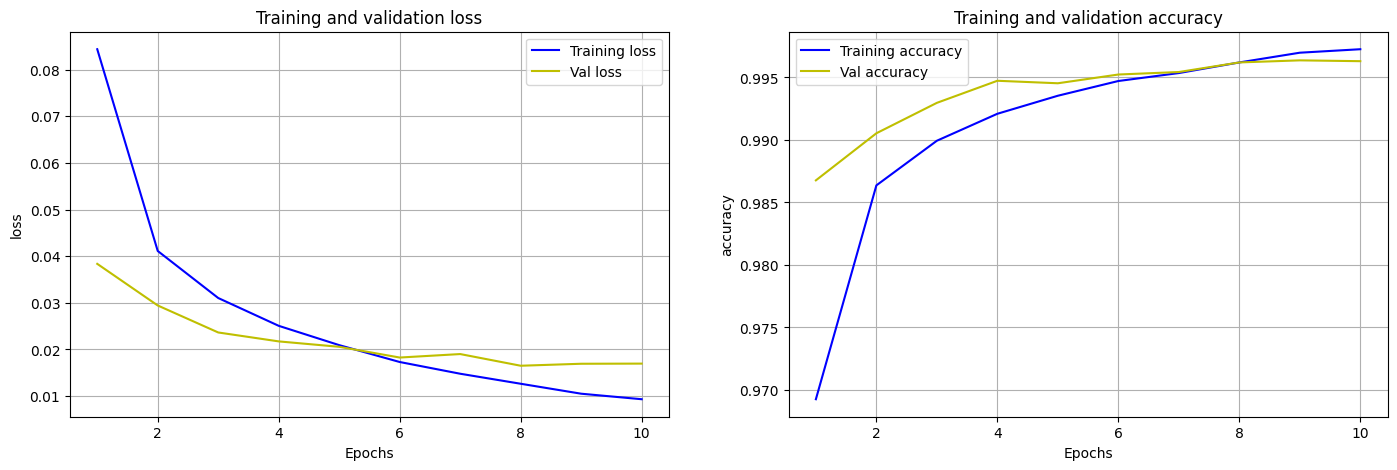

In [42]:
plot(history, EPOCHS, 'accuracy')

Testeo del modelo

In [43]:
print(f"Test accuracy: {model.evaluate(test_ds)[1]*100:.2f} %")

938/938 ━━━━━━━━━━━━━━━━━━━━ 152s 160ms/step - accuracy: 0.9965 - loss: 0.0171
Test accuracy: 99.66 %


##### Pruebas del modelo con textos

Se prueba el modelo con distintos textos y su correspondiente versión escrita por una IA

Creación de un modelo que admite un texto como entrada, lo normaliza, tokeniza y vectoriza y, finalmente, procesa.

In [44]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorizer(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

Texto escrito a mano

In [45]:
# Human version
print("Human version:")

raw_text = """I am the manager of ALTAIR's sales department and I am very upset to hear that you are disappointed with the quality of our software. I would like to apologize to you and ask for more information about your problems with the software.
On the other hand, I inform you that the refund of the money is impossible as stated in the sales contract. However, in some cases we have a customer support policy. A person from our technical department is going to visit your company and check the software running in your computers. Afterwards, a detailed report will be prepared.
Finally, on behalf of the company I must apologize for any inconvenience caused and I would like to offer you the possibility to arrange a meeting to discuss the solutions based on the report. You are one of the most important customer of our company and it would not be pleasant lose our business relationship.
If you have any questions please do not hesitate to contact me and I look forward to hearing from you."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """As the manager of ALTAIR's sales department, I am very sorry to hear about your dissatisfaction with our software. I want to personally apologize and kindly request more details regarding the specific issues you've encountered.
That said, I must inform you that, as outlined in the sales contract, a refund is not possible. However, we do have a customer support policy that may assist in resolving your concerns. A member of our technical team will visit your company to review the software's performance on your systems and prepare a detailed report.
On behalf of ALTAIR, I sincerely apologize for any inconvenience this has caused. I would also like to offer a meeting to discuss potential solutions based on the findings of the report. Your company is a valued client, and we are committed to maintaining our business relationship.
If you have any questions, please don't hesitate to reach out. I look forward to hearing from you."""

predict(raw_text)

Human version:
0.12 % AI generated

AI version:
99.98 % AI generated


The Lord of the Rings, Book 5 Chapter 3, primeros 3 párrafos

In [46]:
# Human version
print("Human version:")

raw_text = """Now all roads were running together to the East to meet the coming of war and the onset of the Shadow. And even as Pippin stood at the Great Gate of the City and saw the Prince of Dol Amroth ride in with his banners, the King of Rohan came down out of the hills. Day was waning. In the last rays of the sun the Riders cast long pointed shadows that went on before them. Darkness had already crept beneath the murmuring fir-woods that clothed the steep mountain-sides.
The king rode now slowly at the end of the day. Presently the path turned round a huge bare shoulder of rock and plunged into the gloom of soft-sighing trees. Down, down they went in a long winding file. When at last they came to the bottom of the gorge they found that evening had fallen in the deep places. The sun was gone. Twilight lay upon the waterfalls.
All day far below them a leaping stream had run down from the high pass behind, cleaving its narrow way between pine-clad walls; and now through a stony gate it flowed out and passed into a wider vale. The Riders followed it, and suddenly Harrowdale lay before them, loud with the noise of waters in the evening. There the white Snowbourn, joined by the lesser stream, went rushing, fuming on the stones, down to Edoras and the green hills and the plains. Away to the right at the head of the great dale the mighty Starkhorn loomed up above its vast buttresses swathed in cloud; but its jagged peak, clothed in everlasting snow, gleamed far above the world, blue-shadowed upon the East, red-stained by the sunset in the West."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Now all the roads converged to the East, drawn to meet the approaching war and the gathering Shadow. As Pippin stood at the City’s Great Gate, watching the Prince of Dol Amroth arrive with his banners, the King of Rohan descended from the hills. The day was fading. In the last sunlight, the Riders cast long, pointed shadows stretching out before them, while darkness had already seeped into the murmuring fir trees that cloaked the steep mountainsides.
The king now rode slowly, the day drawing to a close. The path soon curved around a massive, bare shoulder of rock and plunged into the dimness of softly sighing trees. Down and down they traveled in a long, winding line. When they finally reached the bottom of the gorge, evening had settled thick in the deep places. The sun had disappeared, and twilight lay over the waterfalls.
All day, far below them, a tumbling stream had coursed down from the high pass behind, carving its narrow path between pine-lined walls. Now it flowed through a rocky gate and spread into a broader valley. The Riders followed it until Harrowdale appeared before them, echoing with the roar of evening waters. There, the Snowbourn River, joined by the smaller stream, rushed and fumed over stones, flowing down toward Edoras and the green hills and plains. To the right, at the head of the great valley, the mighty Starkhorn towered above, its vast buttresses draped in clouds. Its jagged peak, clothed in eternal snow, shone far above the world, blue-shadowed in the East, stained red by the sunset in the West."""

predict(raw_text)

Human version:
0.01 % AI generated

AI version:
7.54 % AI generated


Fragmento de la Wikipedia de [Albert Einstein](https://en.wikipedia.org/wiki/Albert_Einstein)

In [47]:
# Human version
print("Human version:")

raw_text = """Correspondence between Einstein and Marić, discovered and published in 1987, revealed that in early 1902, while Marić was visiting her parents in Novi Sad, she gave birth to a daughter, Lieserl. When Marić returned to Switzerland it was without the child, whose fate is uncertain. A letter of Einstein's that he wrote in September 1903 suggests that the girl was either given up for adoption or died of scarlet fever in infancy.
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wrote to Marie Winteler in the months before Eduard's arrival, he described his love for his wife as "misguided" and mourned the "missed life" that he imagined he would have enjoyed if he had married Winteler instead: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein entered into a relationship with Elsa Löwenthal, who was both his first cousin on his mother's side and his second cousin on his father's. When Marić learned of his infidelity soon after moving to Berlin with him in April 1914, she returned to Zürich, taking Hans Albert and Eduard with her. Einstein and Marić were granted a divorce on 14 February 1919 on the grounds of having lived apart for five years. As part of the divorce settlement, Einstein agreed that if he were to win a Nobel Prize, he would give the money that he received to Marić; he won the prize two years later.
Einstein married Löwenthal in 1919. In 1923, he began a relationship with a secretary named Betty Neumann, the niece of his close friend Hans Mühsam. Löwenthal nevertheless remained loyal to him, accompanying him when he emigrated to the United States in 1933. In 1935, she was diagnosed with heart and kidney problems. She died in December 1936."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """In 1987, previously unknown correspondence between Einstein and Marić surfaced, revealing that Marić had given birth to a daughter named Lieserl in early 1902 while visiting her parents in Novi Sad. When Marić returned to Switzerland, the child was not with her, and her fate remains unclear. In a letter Einstein wrote in September 1903, he implied that Lieserl might have been put up for adoption or succumbed to scarlet fever while still an infant.
Einstein and Marić married in January 1903, and the following year, in May 1904, their first son, Hans Albert, was born in Bern, Switzerland. Their second son, Eduard, arrived in Zürich in July 1910. Leading up to Eduard’s birth, Einstein wrote to Marie Winteler, expressing regret over not marrying her instead, referring to his love for Marić as "misguided" and lamenting the "missed life" he believed he would have had with Winteler: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein began an affair with Elsa Löwenthal, his first cousin on his mother's side and his second cousin on his father's. After relocating with Einstein to Berlin in April 1914, Marić discovered his infidelity and soon returned to Zürich with their sons, Hans Albert and Eduard. Their marriage ended in divorce on February 14, 1919, following a five-year separation. As part of the settlement, Einstein promised to give Marić any future Nobel Prize winnings, which he did two years later when he won the award.
Einstein married Löwenthal in 1919, yet by 1923, he was involved with Betty Neumann, the niece of his friend Hans Mühsam. Despite this, Löwenthal stayed by his side, even accompanying him to the United States in 1933. She developed heart and kidney issues in 1935 and passed away in December 1936."""

predict(raw_text)

Human version:
0.00 % AI generated

AI version:
0.00 % AI generated


[Automatic lateral control for unmanned vehicles via genetic algorithms](https://oa.upm.es/13771/2/INVE_MEM_2011_115573.pdf), 5. Conclusions and future works (2011)

In [48]:
# Human version
print("Human version:")

raw_text = """This work has presented an automatic adjustment of fuzzy controllers designed to automatically manage the steering wheel of a mass-produced vehicle which was equipped with the necessary instrumentation and software. To achieve this, an iterative genetic algorithm based method was implemented, capable of iteratively adjusting the membership functions and rule base which define a fuzzy controller. The method applied genetic algorithms with some constraints applied to the controllers to guarantee that the results could perform the automatic driving of an unmanned car.
The controllers also had to have a smooth surface in order to guarantee safe and comfortable driving for the car occupants. The controllers were tested on a private asphalt circuit, and most of them showed good behavior in straight lines, but also bad behavior in curve lines; this is caused by the non-predictive model used in the control, with no analysis of the non-immediate reference points of the desired route. The controllers showed very smooth driving, even when they were circulating at relatively high speeds. This is a good starting point for subsequent research in ITSs.
Subsequent research will focus on improving the models obtained here in order to guarantee precise driving and also comfortable and smooth driving along a reference line. Furthermore, the consequences of using a determined number of membership functions will be studied and any other car state variable, rule base,etc. Safety and efficiency must also not be forgotten. All these important features will be considered in future research."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """This work has introduced an automatic tuning process for fuzzy controllers aimed at managing the steering of a standard vehicle outfitted with essential instrumentation and software. To accomplish this, a method based on an iterative genetic algorithm was employed, allowing for the repeated adjustment of the membership functions and rule base that define a fuzzy controller. The genetic algorithm used specific constraints to ensure the controllers would be capable of autonomously driving an unmanned vehicle. Additionally, the controllers were designed to produce a smooth response to ensure a safe and comfortable experience for passengers.
Testing was conducted on a private asphalt track, and while the controllers generally performed well on straight sections, they struggled on curves. This limitation was attributed to the non-predictive control model used, which lacked analysis of future reference points along the intended path. Despite this, the controllers provided very smooth driving, even at relatively high speeds, which serves as a promising foundation for further Intelligent Transportation Systems (ITS) research.
Future studies will focus on enhancing the models developed here to ensure precise, comfortable, and smooth driving along a predefined route. Additionally, research will explore the impact of varying the number of membership functions and consider additional vehicle state variables and rule base adjustments. Safety and efficiency will remain key priorities, with all these aspects incorporated into future development efforts."""

predict(raw_text)

Human version:
0.04 % AI generated

AI version:
53.09 % AI generated


Fragmento de la noticia [How Donald Trump took the Republican Party by storm](https://edition.cnn.com/2015/12/14/politics/donald-trump-republican-party-history/index.html) de la CNN (2015)

In [49]:
# Human version
print("Human version:")

raw_text = """Conservatives reject such a narrative, and see Obama's own governing style and agenda as largelydriving the grass-roots' frustration - though many in the GOP base think it is the party's failure, despite controlling Congess, to thwart Obama that is as much the problem. Either way, there is certainly some evidence that Trump has latched onto the anti-Washington fervor of the tea party and the issues that animate members of a group at first assumed to be preoccupied with economic concerns but shown by political scientists to represent a wider set of beliefs.
For instance, his decision to make opposition to illegal immigration a foundation of his campaign looks particularly shrewd and has helped him to connect with the visceral discontent electrifying the conservative movement.
A study by three Harvard scholars in 2011 found that immigration was almost as much of a motivating force for tea party voters as deficits and spending. Some 80% of tea party voters said illegal immigration was a “very serious problem.”
The study by Vanessa Williamson, Theda Skocpol and John Coggin also identified that the societal change in America epitomized by Obama - intoxicating to his supporters - is deeply troubling and almost frightening to tea party voters.
Trump's stump speech, the soft rock 1980s soundtrack that pumps through his rallies and his vows to “make America great again” seem to hark back to a simpler, less diverse, more traditional nation, before blue-collar jobs migrated to China and American power was feared in the world.
“I think the best explanation (for Trump's popularity) is this change and this disequilibrium that we are seeing in American society,” said Dan Shea, a professor of political science at Maine's Colby College, who has studied the polarization of the electorate.
Shea said Trump's rise was a natural extension of the upheaval of the tea party era, born in the dislocation of the Great Recession, the fallout of two wars and sweeping change on issues like gay rights."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Conservatives reject this view, arguing that Obama's own leadership style and policy agenda are the primary sources of grassroots frustration. Many in the GOP base, however, also feel that their party's failure to block Obama’s actions—even with control of Congress—is a major factor. Regardless, Trump appears to have tapped into the anti-establishment sentiment that originated with the tea party, a movement initially seen as focused on economic issues but later shown by political researchers to embody a broader set of beliefs.
For example, Trump's decision to spotlight opposition to illegal immigration as a key element of his campaign has resonated with the underlying dissatisfaction within the conservative movement. In fact, a 2011 study by three Harvard researchers indicated that immigration was nearly as influential to tea party supporters as concerns about deficits and government spending, with 80% of tea party members viewing illegal immigration as a “very serious problem.”
The study by Vanessa Williamson, Theda Skocpol, and John Coggin also found that the social changes in America, symbolized by Obama and inspiring to his supporters, were unsettling or even alarming to tea party followers. Trump’s speeches, the nostalgic 1980s rock music at his rallies, and his slogan to “make America great again” seem to appeal to a vision of America that is simpler, less diverse, and more traditional, harkening back to a time before manufacturing jobs moved overseas and America's global influence was unquestioned.
According to Dan Shea, a political science professor at Colby College in Maine who studies voter polarization, Trump’s popularity can best be explained by the upheaval and societal imbalance currently affecting American society. Shea points out that Trump’s rise is a natural outgrowth of the tea party movement, rooted in the economic dislocation of the Great Recession, the impact of two wars, and the rapid changes surrounding issues like gay rights."""

predict(raw_text)

Human version:
0.00 % AI generated

AI version:
19.41 % AI generated


#### Codificación "int" + Transformer encoder con Positional Embedding

Creación de la capa _PositionalEmbedding_

In [50]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        positions = self.position_embeddings(positions)
        embedded_tokens = self.token_embeddings(inputs)
        positions = tf.expand_dims(positions, axis=0)
        
        return embedded_tokens + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Preprocesado de los textos con codificación int, 40000 tokens de vocabulario y 500 tokens de longitud máxima de secuencia

In [51]:
max_length = 500
max_tokens = 40000
out = "int"

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                    output_mode=out,
                                    standardize=custom_standardization,
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_df['text_cleaned'].values)

train_ds, val_ds, test_ds = format(train_df, test_df, val_df, text_vectorizer)

Diseño del modelo

In [52]:
# Se ha aumentado el tamaño del embedding a 256
embed_dim = 256
num_heads = 2
dense_dim = 32
EPOCHS = 10

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(max_length, max_tokens, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, None, 256)      │    10,368,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, None, 256)      │       543,776 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,912,033 (41.63 MB)

 Trainable params: 10,912,033 (41.63 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo, guardando tanto el propio modelo como el historial

In [ ]:
history = model.fit(train_ds.cache(),
          validation_data=val_ds.cache(),
          epochs=EPOCHS, batch_size=128)

model.save("models/model_4.keras")

with open('models/model_4_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2661s 607ms/step - accuracy: 0.9239 - loss: 0.1973 - val_accuracy: 0.9870 - val_loss: 0.0370
Epoch 2/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2751s 629ms/step - accuracy: 0.9848 - loss: 0.0459 - val_accuracy: 0.9907 - val_loss: 0.0292
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2649s 606ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.9920 - val_loss: 0.0227
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2638s 603ms/step - accuracy: 0.9921 - loss: 0.0247 - val_accuracy: 0.9935 - val_loss: 0.0208
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2652s 606ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.9934 - val_loss: 0.0237
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2659s 608ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9944 - val_loss: 0.0181
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2670s 610ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9936 - val_loss: 0.0243
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2678s 612ms/step - accur

Carga del modelo y del historial

In [ ]:
model = keras.models.load_model("models/model_4.keras", custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder})

with open('models/model_4_history.pkl', 'rb') as f:
    history = pickle.load(f)

c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Gráfico del historial del entrenamiento

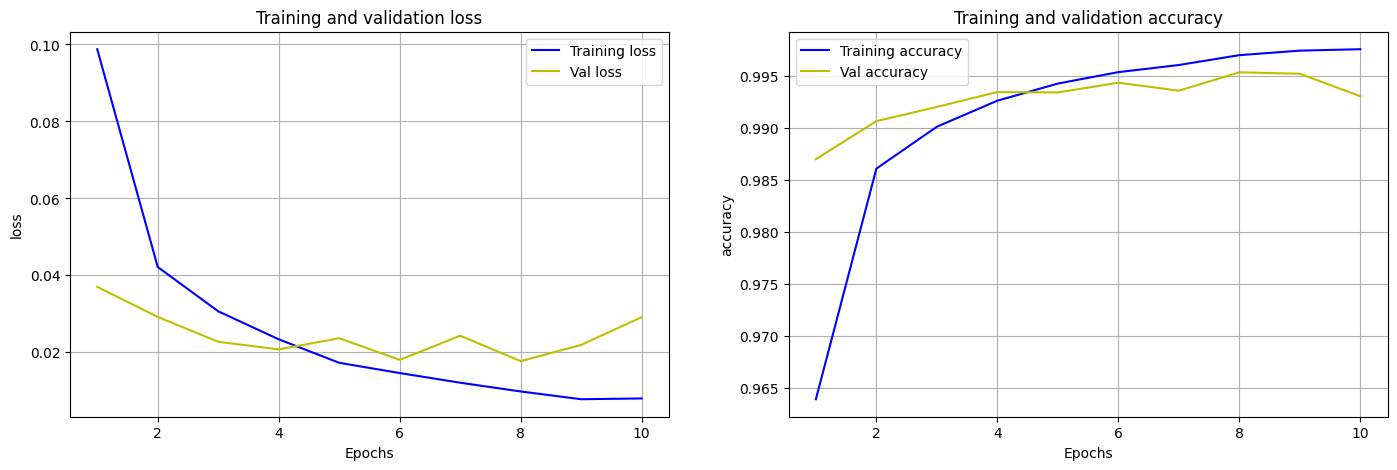

In [54]:
plot(history, EPOCHS, 'accuracy')

Testeo del modelo

In [55]:
print(f"Test accuracy: {model.evaluate(test_ds)[1]*100:.2f} %")

938/938 ━━━━━━━━━━━━━━━━━━━━ 198s 209ms/step - accuracy: 0.9936 - loss: 0.0262
Test accuracy: 99.30 %


##### Pruebas del modelo con textos

Se prueba el modelo con distintos textos y su correspondiente versión escrita por una IA

Creación de un modelo que admite un texto como entrada, lo normaliza, tokeniza y vectoriza y, finalmente, procesa.

In [56]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorizer(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

Texto escrito a mano

In [57]:
# Human version
print("Human version:")

raw_text = """I am the manager of ALTAIR's sales department and I am very upset to hear that you are disappointed with the quality of our software. I would like to apologize to you and ask for more information about your problems with the software.
On the other hand, I inform you that the refund of the money is impossible as stated in the sales contract. However, in some cases we have a customer support policy. A person from our technical department is going to visit your company and check the software running in your computers. Afterwards, a detailed report will be prepared.
Finally, on behalf of the company I must apologize for any inconvenience caused and I would like to offer you the possibility to arrange a meeting to discuss the solutions based on the report. You are one of the most important customer of our company and it would not be pleasant lose our business relationship.
If you have any questions please do not hesitate to contact me and I look forward to hearing from you."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """As the manager of ALTAIR's sales department, I am very sorry to hear about your dissatisfaction with our software. I want to personally apologize and kindly request more details regarding the specific issues you've encountered.
That said, I must inform you that, as outlined in the sales contract, a refund is not possible. However, we do have a customer support policy that may assist in resolving your concerns. A member of our technical team will visit your company to review the software's performance on your systems and prepare a detailed report.
On behalf of ALTAIR, I sincerely apologize for any inconvenience this has caused. I would also like to offer a meeting to discuss potential solutions based on the findings of the report. Your company is a valued client, and we are committed to maintaining our business relationship.
If you have any questions, please don't hesitate to reach out. I look forward to hearing from you."""

predict(raw_text)

Human version:
0.02 % AI generated

AI version:
99.72 % AI generated


The Lord of the Rings, Book 5 Chapter 3, primeros 3 párrafos

In [58]:
# Human version
print("Human version:")

raw_text = """Now all roads were running together to the East to meet the coming of war and the onset of the Shadow. And even as Pippin stood at the Great Gate of the City and saw the Prince of Dol Amroth ride in with his banners, the King of Rohan came down out of the hills. Day was waning. In the last rays of the sun the Riders cast long pointed shadows that went on before them. Darkness had already crept beneath the murmuring fir-woods that clothed the steep mountain-sides.
The king rode now slowly at the end of the day. Presently the path turned round a huge bare shoulder of rock and plunged into the gloom of soft-sighing trees. Down, down they went in a long winding file. When at last they came to the bottom of the gorge they found that evening had fallen in the deep places. The sun was gone. Twilight lay upon the waterfalls.
All day far below them a leaping stream had run down from the high pass behind, cleaving its narrow way between pine-clad walls; and now through a stony gate it flowed out and passed into a wider vale. The Riders followed it, and suddenly Harrowdale lay before them, loud with the noise of waters in the evening. There the white Snowbourn, joined by the lesser stream, went rushing, fuming on the stones, down to Edoras and the green hills and the plains. Away to the right at the head of the great dale the mighty Starkhorn loomed up above its vast buttresses swathed in cloud; but its jagged peak, clothed in everlasting snow, gleamed far above the world, blue-shadowed upon the East, red-stained by the sunset in the West."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Now all the roads converged to the East, drawn to meet the approaching war and the gathering Shadow. As Pippin stood at the City’s Great Gate, watching the Prince of Dol Amroth arrive with his banners, the King of Rohan descended from the hills. The day was fading. In the last sunlight, the Riders cast long, pointed shadows stretching out before them, while darkness had already seeped into the murmuring fir trees that cloaked the steep mountainsides.
The king now rode slowly, the day drawing to a close. The path soon curved around a massive, bare shoulder of rock and plunged into the dimness of softly sighing trees. Down and down they traveled in a long, winding line. When they finally reached the bottom of the gorge, evening had settled thick in the deep places. The sun had disappeared, and twilight lay over the waterfalls.
All day, far below them, a tumbling stream had coursed down from the high pass behind, carving its narrow path between pine-lined walls. Now it flowed through a rocky gate and spread into a broader valley. The Riders followed it until Harrowdale appeared before them, echoing with the roar of evening waters. There, the Snowbourn River, joined by the smaller stream, rushed and fumed over stones, flowing down toward Edoras and the green hills and plains. To the right, at the head of the great valley, the mighty Starkhorn towered above, its vast buttresses draped in clouds. Its jagged peak, clothed in eternal snow, shone far above the world, blue-shadowed in the East, stained red by the sunset in the West."""

predict(raw_text)

Human version:
0.03 % AI generated

AI version:
99.92 % AI generated


Fragmento de la Wikipedia de [Albert Einstein](https://en.wikipedia.org/wiki/Albert_Einstein)

In [59]:
# Human version
print("Human version:")

raw_text = """Correspondence between Einstein and Marić, discovered and published in 1987, revealed that in early 1902, while Marić was visiting her parents in Novi Sad, she gave birth to a daughter, Lieserl. When Marić returned to Switzerland it was without the child, whose fate is uncertain. A letter of Einstein's that he wrote in September 1903 suggests that the girl was either given up for adoption or died of scarlet fever in infancy.
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wrote to Marie Winteler in the months before Eduard's arrival, he described his love for his wife as "misguided" and mourned the "missed life" that he imagined he would have enjoyed if he had married Winteler instead: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein entered into a relationship with Elsa Löwenthal, who was both his first cousin on his mother's side and his second cousin on his father's. When Marić learned of his infidelity soon after moving to Berlin with him in April 1914, she returned to Zürich, taking Hans Albert and Eduard with her. Einstein and Marić were granted a divorce on 14 February 1919 on the grounds of having lived apart for five years. As part of the divorce settlement, Einstein agreed that if he were to win a Nobel Prize, he would give the money that he received to Marić; he won the prize two years later.
Einstein married Löwenthal in 1919. In 1923, he began a relationship with a secretary named Betty Neumann, the niece of his close friend Hans Mühsam. Löwenthal nevertheless remained loyal to him, accompanying him when he emigrated to the United States in 1933. In 1935, she was diagnosed with heart and kidney problems. She died in December 1936."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """In 1987, previously unknown correspondence between Einstein and Marić surfaced, revealing that Marić had given birth to a daughter named Lieserl in early 1902 while visiting her parents in Novi Sad. When Marić returned to Switzerland, the child was not with her, and her fate remains unclear. In a letter Einstein wrote in September 1903, he implied that Lieserl might have been put up for adoption or succumbed to scarlet fever while still an infant.
Einstein and Marić married in January 1903, and the following year, in May 1904, their first son, Hans Albert, was born in Bern, Switzerland. Their second son, Eduard, arrived in Zürich in July 1910. Leading up to Eduard’s birth, Einstein wrote to Marie Winteler, expressing regret over not marrying her instead, referring to his love for Marić as "misguided" and lamenting the "missed life" he believed he would have had with Winteler: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be."
In 1912, Einstein began an affair with Elsa Löwenthal, his first cousin on his mother's side and his second cousin on his father's. After relocating with Einstein to Berlin in April 1914, Marić discovered his infidelity and soon returned to Zürich with their sons, Hans Albert and Eduard. Their marriage ended in divorce on February 14, 1919, following a five-year separation. As part of the settlement, Einstein promised to give Marić any future Nobel Prize winnings, which he did two years later when he won the award.
Einstein married Löwenthal in 1919, yet by 1923, he was involved with Betty Neumann, the niece of his friend Hans Mühsam. Despite this, Löwenthal stayed by his side, even accompanying him to the United States in 1933. She developed heart and kidney issues in 1935 and passed away in December 1936."""

predict(raw_text)

Human version:


13.61 % AI generated

AI version:
93.17 % AI generated


[Automatic lateral control for unmanned vehicles via genetic algorithms](https://oa.upm.es/13771/2/INVE_MEM_2011_115573.pdf), 5. Conclusions and future works (2011)

In [60]:
# Human version
print("Human version:")

raw_text = """This work has presented an automatic adjustment of fuzzy controllers designed to automatically manage the steering wheel of a mass-produced vehicle which was equipped with the necessary instrumentation and software. To achieve this, an iterative genetic algorithm based method was implemented, capable of iteratively adjusting the membership functions and rule base which define a fuzzy controller. The method applied genetic algorithms with some constraints applied to the controllers to guarantee that the results could perform the automatic driving of an unmanned car.
The controllers also had to have a smooth surface in order to guarantee safe and comfortable driving for the car occupants. The controllers were tested on a private asphalt circuit, and most of them showed good behavior in straight lines, but also bad behavior in curve lines; this is caused by the non-predictive model used in the control, with no analysis of the non-immediate reference points of the desired route. The controllers showed very smooth driving, even when they were circulating at relatively high speeds. This is a good starting point for subsequent research in ITSs.
Subsequent research will focus on improving the models obtained here in order to guarantee precise driving and also comfortable and smooth driving along a reference line. Furthermore, the consequences of using a determined number of membership functions will be studied and any other car state variable, rule base,etc. Safety and efficiency must also not be forgotten. All these important features will be considered in future research."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """This work has introduced an automatic tuning process for fuzzy controllers aimed at managing the steering of a standard vehicle outfitted with essential instrumentation and software. To accomplish this, a method based on an iterative genetic algorithm was employed, allowing for the repeated adjustment of the membership functions and rule base that define a fuzzy controller. The genetic algorithm used specific constraints to ensure the controllers would be capable of autonomously driving an unmanned vehicle. Additionally, the controllers were designed to produce a smooth response to ensure a safe and comfortable experience for passengers.
Testing was conducted on a private asphalt track, and while the controllers generally performed well on straight sections, they struggled on curves. This limitation was attributed to the non-predictive control model used, which lacked analysis of future reference points along the intended path. Despite this, the controllers provided very smooth driving, even at relatively high speeds, which serves as a promising foundation for further Intelligent Transportation Systems (ITS) research.
Future studies will focus on enhancing the models developed here to ensure precise, comfortable, and smooth driving along a predefined route. Additionally, research will explore the impact of varying the number of membership functions and consider additional vehicle state variables and rule base adjustments. Safety and efficiency will remain key priorities, with all these aspects incorporated into future development efforts."""

predict(raw_text)

Human version:


31.62 % AI generated

AI version:
100.00 % AI generated


Fragmento de la noticia [How Donald Trump took the Republican Party by storm](https://edition.cnn.com/2015/12/14/politics/donald-trump-republican-party-history/index.html) de la CNN (2015)

In [61]:
# Human version
print("Human version:")

raw_text = """Conservatives reject such a narrative, and see Obama's own governing style and agenda as largelydriving the grass-roots' frustration - though many in the GOP base think it is the party's failure, despite controlling Congess, to thwart Obama that is as much the problem. Either way, there is certainly some evidence that Trump has latched onto the anti-Washington fervor of the tea party and the issues that animate members of a group at first assumed to be preoccupied with economic concerns but shown by political scientists to represent a wider set of beliefs.
For instance, his decision to make opposition to illegal immigration a foundation of his campaign looks particularly shrewd and has helped him to connect with the visceral discontent electrifying the conservative movement.
A study by three Harvard scholars in 2011 found that immigration was almost as much of a motivating force for tea party voters as deficits and spending. Some 80% of tea party voters said illegal immigration was a “very serious problem.”
The study by Vanessa Williamson, Theda Skocpol and John Coggin also identified that the societal change in America epitomized by Obama - intoxicating to his supporters - is deeply troubling and almost frightening to tea party voters.
Trump's stump speech, the soft rock 1980s soundtrack that pumps through his rallies and his vows to “make America great again” seem to hark back to a simpler, less diverse, more traditional nation, before blue-collar jobs migrated to China and American power was feared in the world.
“I think the best explanation (for Trump's popularity) is this change and this disequilibrium that we are seeing in American society,” said Dan Shea, a professor of political science at Maine's Colby College, who has studied the polarization of the electorate.
Shea said Trump's rise was a natural extension of the upheaval of the tea party era, born in the dislocation of the Great Recession, the fallout of two wars and sweeping change on issues like gay rights."""

predict(raw_text)

# AI version
print("\nAI version:")

raw_text = """Conservatives reject this view, arguing that Obama's own leadership style and policy agenda are the primary sources of grassroots frustration. Many in the GOP base, however, also feel that their party's failure to block Obama’s actions—even with control of Congress—is a major factor. Regardless, Trump appears to have tapped into the anti-establishment sentiment that originated with the tea party, a movement initially seen as focused on economic issues but later shown by political researchers to embody a broader set of beliefs.
For example, Trump's decision to spotlight opposition to illegal immigration as a key element of his campaign has resonated with the underlying dissatisfaction within the conservative movement. In fact, a 2011 study by three Harvard researchers indicated that immigration was nearly as influential to tea party supporters as concerns about deficits and government spending, with 80% of tea party members viewing illegal immigration as a “very serious problem.”
The study by Vanessa Williamson, Theda Skocpol, and John Coggin also found that the social changes in America, symbolized by Obama and inspiring to his supporters, were unsettling or even alarming to tea party followers. Trump’s speeches, the nostalgic 1980s rock music at his rallies, and his slogan to “make America great again” seem to appeal to a vision of America that is simpler, less diverse, and more traditional, harkening back to a time before manufacturing jobs moved overseas and America's global influence was unquestioned.
According to Dan Shea, a political science professor at Colby College in Maine who studies voter polarization, Trump’s popularity can best be explained by the upheaval and societal imbalance currently affecting American society. Shea points out that Trump’s rise is a natural outgrowth of the tea party movement, rooted in the economic dislocation of the Great Recession, the impact of two wars, and the rapid changes surrounding issues like gay rights."""

predict(raw_text)

Human version:


0.10 % AI generated

AI version:
99.65 % AI generated
